1. Preparations

In [24]:
import evaluation as eval
import numpy as np
import pandas as pd
import os
import json
from enum import Enum
import matplotlib.pyplot as plt

In [25]:
def get_pdf_summary_path() -> str:
    result = os.path.abspath('..\\..\\resources\\benchmark\\pdf_summary')
    return result

def get_pdf_summary_subpath(subpath:str) -> str:
    result = os.path.join(
        get_pdf_summary_path(), 
        subpath
    )
    return result

2. Load Files into dictionaries

In [26]:
class SumAlgo(Enum):
    LSA = 'lsa'
    TEXTRANK = 'textrank'
    BART = 'bart'
    FALCON = 'falcon'
    STABLE_LM = 'stablelm'
    TEXTRANK_BART = 'textrank_bart'
    TEXTRANK_FALCON = 'textrank_falcon'
    TEXTRANK_STABLELM = 'textrank_stablelm'
    LSA_BART = 'lsa_bart'
    LSA_FALCON = 'lsa_falcon'
    LSA_STABLELM = 'lsa_stablelm'
    REF = 'ref'

def get_file_name_list() -> list[str]:
    list = []
    for (_, _, filenames) in os.walk(get_pdf_summary_subpath(SumAlgo.REF.value)):
        for filename in filenames:
            list.append(filename.rstrip('.grobid.tei.xml.json'))
    return list

def get_file_path_list(sumAlgo:SumAlgo) -> list[str]:
    list = []
    for (dirpath, _, filenames) in os.walk(get_pdf_summary_subpath(sumAlgo.value)):
        for filename in filenames:
            list.append(os.path.join(dirpath, filename))
    return list

def get_file_dict(sumAlgo:SumAlgo) -> dict:
    path_list = get_file_path_list(sumAlgo) 
    file_name_list = get_file_name_list()
    # print(len(path_list), path_list)
    result = {}
    for i in range(0, len(file_name_list)):
        # print(i, file_name_list[i])
        # print(i, path_list[i])
        path = path_list[i]
        file_name = file_name_list[i]
        result[file_name] = read_file(path)
    return result 

def read_file(path:str) -> any:
    result = ''
    with open(path, 'r') as f:
        result = json.load(f)
    return result

def get_segment_dict(sumAlgo:SumAlgo) -> dict:
    file_dict = get_file_dict(sumAlgo)
    file_name_list = get_file_name_list()
    result = {}
    for file_name in file_name_list:
        value = file_dict[file_name]
        segments = value['segments']
        result[file_name] = segments
    return result

ref_segment_dict = get_segment_dict(SumAlgo.REF)
textrank_segment_dict = get_segment_dict(SumAlgo.TEXTRANK)
lsa_segment_dict = get_segment_dict(SumAlgo.LSA)
file_name_list = get_file_name_list()

3. Evaluate

In [27]:
# Mean rouge_1 of all paragraphs
def get_header_dict(segments:list) -> dict:
    result = {}
    for segment in segments:
        header = segment['header']
        content = segment['content']
        result[header] = content
    return result 

def get_eval_by_header(ref_header_dict:dict, test_header_dict:dict, eval_method:eval.EvalMethod, sum_algo:SumAlgo) -> pd.DataFrame:
    ref_key_num = len(ref_header_dict.keys())
    test_key_num = len(test_header_dict.keys())
    if(ref_key_num != test_key_num):
        print("The number of keys do not match: " + len(ref_header_dict.keys()) + " " + len(ref_header_dict.keys()))
            
    result = {}
    for i in range(0, len(test_header_dict.keys())):
        header = list(ref_header_dict.keys())[i]
        ref_content = ref_header_dict[header].lower()
        test_content = test_header_dict[header].lower()
        # print(sum_algo.value)
        # print(ref_content)
        eval_result = eval.eval_method_dict[eval_method](test_content, ref_content)
        result[header] = [eval_result]
    
    return pd.DataFrame(result, index=[eval_method.value]).transpose()

def evaluate(sum_algo:SumAlgo, ref_segment_dict:dict, eval_method:eval.EvalMethod) -> pd.DataFrame:
    test_segment_dict = get_segment_dict(sum_algo)
    file_name_list = get_file_name_list()
    result = {}
    result_list = []
    for file_name in file_name_list:
        ref_header_dict = get_header_dict(ref_segment_dict[file_name])
        test_header_dict = get_header_dict(test_segment_dict[file_name])
        eval_header = get_eval_by_header(ref_header_dict, test_header_dict, eval_method, sum_algo)
        eval_value_list = eval_header[eval_method.value].to_list()
        eval_average = sum(eval_value_list) / len(eval_value_list)
        # print(eval_average) 
        result_list.append(eval_average)
        # break
    result[eval_method.value] = result_list
    df = pd.DataFrame(result, index=file_name_list)
    df.index.name
    return df

def evaluate_all_method(sum_algo:SumAlgo, ref_segment_dict:dict) -> pd.DataFrame:
    file_name_list = get_file_name_list()
    file_name_list.append("Total")
    file_name_list.append("Average")
    result = {}
    for method in eval.EvalMethod:
        eval_df = evaluate(sum_algo, ref_segment_dict, method)
        result_list = eval_df[method.value].to_list()   

        total = 0
        total = sum(result_list)
        average = total/len(result_list)
        result_list.append(total)
        result_list.append(average)

        result[method.value] = result_list

    df = pd.DataFrame(result, index=file_name_list)
    df.index.name = sum_algo.value
    return df

def evaluate_all_sum_algo(ref_segment_dict:dict) -> pd.DataFrame:
    # Data extraction
    average_list_map = {}
    method_list = [x.value for x in eval.EvalMethod]

    for algo in SumAlgo:
        if(algo == SumAlgo.REF):
            continue
        df = evaluate_all_method(algo, ref_segment_dict)

        average_list = []
        for method_value in method_list:
            average = df[method_value]["Average"]
            average_list.append(average)
        average_list_map[algo] = average_list
    
    df = pd.DataFrame(average_list_map, index=method_list)
    return df
       
# print(evaluate(lsa_segment_dict, ref_segment_dict, eval.EvalMethod.ROUGE_1))
# evaluate_all_method(SumAlgo.LSA, ref_segment_dict)


evaluate_all_sum_algo(ref_segment_dict)

,SumAlgo.LSA,SumAlgo.TEXTRANK,SumAlgo.BART,SumAlgo.FALCON,SumAlgo.STABLE_LM,SumAlgo.TEXTRANK_BART,SumAlgo.TEXTRANK_FALCON,SumAlgo.TEXTRANK_STABLELM,SumAlgo.LSA_BART,SumAlgo.LSA_FALCON,SumAlgo.LSA_STABLELM
rouge_1,0.502153,0.446608,0.500143,0.475585,0.530595,0.565338,0.521697,0.585241,0.532834,0.484316,0.524413
rouge_2,0.129708,0.134224,0.154753,0.132557,0.221119,0.204300,0.181454,0.269883,0.151566,0.136793,0.208317
rouge_l,0.502153,0.446608,0.500143,0.475585,0.530595,0.565338,0.521697,0.585241,0.532834,0.484316,0.524413


<Figure size 640x480 with 0 Axes>

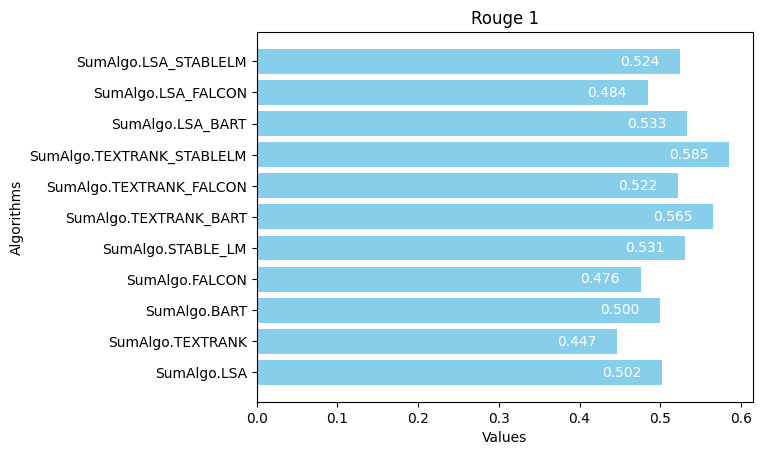

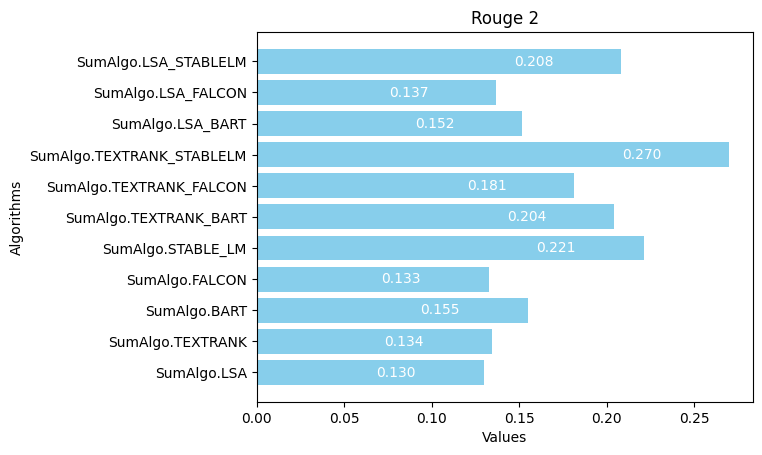

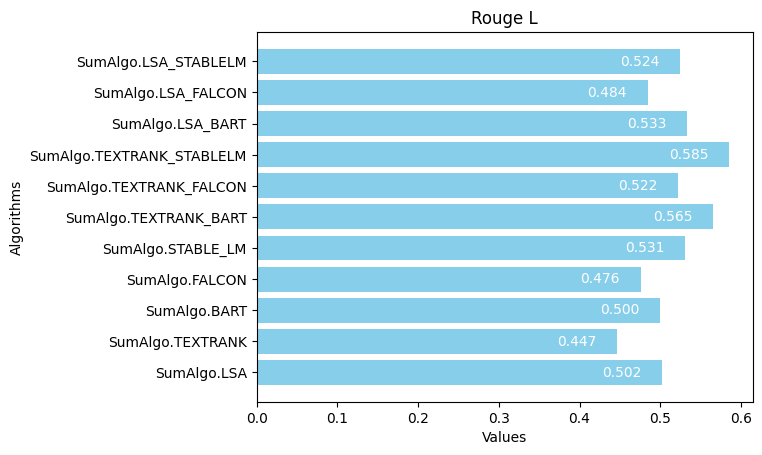

In [28]:
df = evaluate_all_sum_algo(ref_segment_dict)

plt.figure()

method_list = [x.value for x in eval.EvalMethod]
for method in method_list:
    fig, ax = plt.subplots()
    
    # Extract the row for method
    row = df.loc[method]
    
    # Create a horizontal bar plot
    row.index = row.index.astype(str)
    
    # Plot the horizontal bar plot for rouge_1 row
    bars = ax.barh(row.index, row.values, color='skyblue')
    
    # Annotate each bar with its value
    for bar in bars:
        ax.text(bar.get_width() - 0.05, bar.get_y() + bar.get_height() / 2, 
                f'{bar.get_width():.3f}', ha='center', va='center', color='white')

    ax.set_xlabel('Values')
    ax.set_ylabel('Algorithms')
    # Capitalize the first letter, remove "_" and capitalize the last letter
    ax.set_title(method[:1].capitalize() + method[1:-1].replace("_", " ") + method[-1:].capitalize())  
